# DSE Dissertation

## Topic Analysis

In [ ]:
# Mount Google Drive to access required files

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Load Packages

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sn
from wordcloud import WordCloud
import re
import spacy
import codecs

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
!pip install Unidecode
import unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 4.1 MB/s eta 0:00:00


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix

#### Load Dataset

In [5]:
"""

Loading dataset

"""

class UtteranceExample:
    def __init__(self, text, label, do_lower_case):
        self.original_text = text
        self.text = text
        self.label = label

        if do_lower_case:
            self.text = self.text.lower()

    def to_dict(self):
      return {
          'utterance': self.original_text,
          'intent': self.label,
      }
        
def load_utterance_examples(file_path, do_lower_case=True):
    examples = []

    with open('{}/seq.in'.format(file_path), 'r', encoding="utf-8") as f_text, open('{}/label'.format(file_path), 'r', encoding="utf-8") as f_label:
        for text, label in zip(f_text, f_label):
            e = UtteranceExample(text.strip(), label.strip(), do_lower_case)
            examples.append(e)

    return examples



In [6]:
data = load_utterance_examples("/content/drive/MyDrive/Dissertation/Topic_Analysis/dataset/train")

utterances= pd.DataFrame.from_records([d.to_dict() for d in data])

print(utterances)

                                              utterance           intent
0                        i am still waiting on my card?     card_arrival
1     what can i do if my card still hasn't arrived ...     card_arrival
2     i have been waiting over a week. is the card s...     card_arrival
3     can i track my card while it is in the process...     card_arrival
4     how do i know if i will get my card, or if it ...     card_arrival
...                                                 ...              ...
8617             you provide support in what countries?  country_support
8618                 what countries are you supporting?  country_support
8619                what countries are getting support?  country_support
8620                     are cards available in the eu?  country_support
8621                   which countries are represented?  country_support

[8622 rows x 2 columns]


### Exploratory Data Analysis

In [7]:
utterances.shape

(8622, 2)

In [8]:
utterances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8622 entries, 0 to 8621
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   utterance  8622 non-null   object
 1   intent     8622 non-null   object
dtypes: object(2)
memory usage: 134.8+ KB


In [9]:
utterances.describe()

,utterance,intent
count,8622,8622
unique,8618,77
top,where can i withdraw money from?,card_payment_fee_charged
freq,2,167


In [10]:
#Few samples of the dataset.

utterances.head()

,utterance,intent
0,i am still waiting on my card?,card_arrival
1,what can i do if my card still hasn't arrived ...,card_arrival
2,i have been waiting over a week. is the card s...,card_arrival
3,can i track my card while it is in the process...,card_arrival
4,"how do i know if i will get my card, or if it ...",card_arrival


In [11]:
utterances.dropna(axis=0,inplace=True)#dropping na
utterances.shape

(8622, 2)

In [12]:
utterances.drop_duplicates(subset=['utterance'],inplace=True)#dropping duplicates
utterances.shape

(8618, 2)

In [13]:
#Look for missing intents
utterances['intent'].isnull().sum()

0

In [14]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

type_counts_train = utterances['intent'].value_counts(sort=True, ascending=True)

#Another way of printing the values.
#print(pd.DataFrame({'count' : utterances.groupby( [ "intent"] ).size()}).reset_index().sort_values('count'))

print(type_counts_train)

"""

It shows that the utterances per intent are imbalanced.

TOTAL OF 77 INTENT CLASSES

"""
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', 5)

contactless_not_working                              30
virtual_card_not_working                             32
card_swallowed                                       45
card_acceptance                                      47
lost_or_stolen_card                                  66
atm_support                                          68
compromised_card                                     72
get_disposable_virtual_card                          78
top_up_limits                                        79
receiving_money                                      80
getting_virtual_card                                 82
unable_to_verify_identity                            86
passcode_forgotten                                   87
verify_my_identity                                   87
topping_up_by_card                                   87
get_physical_card                                    88
terminate_account                                    91
age_limit                                       

### Data Pre-processing.
- Spelling correction.
- Remove Punctuation.
- Remove stop words.
- Tokenization.
- Lemmatization.


In [15]:
! pip install -U symspellpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.9/126.9 KB 9.9 MB/s eta 0:00:00


In [16]:
#Spelling correction using Symspell.

from symspellpy import SymSpell
import pkg_resources
from itertools import islice

##### Creating a dictionary out of dataset

In [19]:
# Idea is to generate a dictionary out of dataset and feed as input to symspell as one of the inputs.
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

isDictionaryCreated = sym_spell.create_dictionary("/content/drive/MyDrive/Dissertation/Topic_Analysis/dataset/train/seq.in")
isDictionaryCreated

True

In [20]:
# Load the dictionaries provided by library

dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename("symspellpy", "frequency_bigramdictionary_en_243_342.txt")

# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# Print out first 5 elements to demonstrate that dictionary is
# successfully loaded
#print(list(islice(sym_spell.bigrams.items(), 5)))
#print(list(islice(sym_spell.words.items(), 5)))

# lookup suggestions for multi-word input strings (supports compound
# splitting & merging)
input_term = (
    "how do i loacte my card?"
)
# max edit distance per lookup (per single word, not per whole input string)
suggestions = sym_spell.lookup_compound(input_term, max_edit_distance=2)
# display suggestion term, edit distance, and term frequency
for suggestion in suggestions:
    print(suggestion)

def spell_correction(input_term, max_edit_distance=2):
  suggestions = sym_spell.lookup_compound(input_term, max_edit_distance=2)
  #for suggestion in suggestions:
  #  print(suggestion.term)
  return suggestions[0].term

how do i locate my card, 2, 0


In [21]:
# call the function spell_correction

corrected_utterances = []

for t in utterances['utterance']:
    corrected_utterances.append(spell_correction(t)) 

corrected_utterances[:5]
utterances['utterance'] = corrected_utterances
utterances.head()

,utterance,intent
0,i am still waiting on my card,card_arrival
1,what can i do if my card still hasn't arrived ...,card_arrival
2,i have been waiting over a week is the card st...,card_arrival
3,can i track my card while it is in the process...,card_arrival
4,how do i know if i will get my card or if it i...,card_arrival


In [22]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [23]:
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')
nltk.download("wordnet")
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [24]:
stop_words = set(stopwords.words('english')) 

# Text cleanup using regex
def text_cleaner(text):
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)   # removing special characters
    newString = re.sub('"','', newString)              # removing '"' 
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    # replacing slangs
    newString = re.sub(r"'s\b","",newString)    # replacing 's with "" '
    newString = re.sub("[^a-z]", " ", newString)    #only keeping letters
    newString = re.sub('[m]{2,}', 'mm', newString)    # "mmmmmm" -> "mm"
        
    tokens = [w for w in newString.split() if not w in stop_words]     # removing the stopwords

    long_words=[]
    for i in tokens:
        if len(i)>1:                               #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

    
#Lemmatization

def lemma(tokenized_text):
  wordnetLemmatizer = nltk.WordNetLemmatizer()
  text = [wordnetLemmatizer.lemmatize(word) for word in tokenized_text]
  return (" ".join(text)).strip()

In [ ]:
#call the function text_cleaner if you want to use text pre-processing using text_cleaner method.
cleaned_text = []
for t in utterances['utterance']:
    cleaned_text.append(text_cleaner(t)) 

utterances['cleaned_utterance'] = cleaned_text
utterances['lemmatized_utterance'] = utterances['cleaned_utterance'].apply(lambda x: lemma(x.split(" ")))

#Drop empty rows
utterances.replace('', np.nan, inplace=True)
utterances.dropna(axis=0,inplace=True)

utterances.head()

,utterance,intent,cleaned_utterance,lemmatized_utterance
0,i am still waiting on my card,card_arrival,still waiting card,still waiting card
1,what can i do if my card still hasn't arrived ...,card_arrival,card still arrived weeks,card still arrived week
2,i have been waiting over a week is the card st...,card_arrival,waiting week card still coming,waiting week card still coming
3,can i track my card while it is in the process...,card_arrival,track card process delivery,track card process delivery
4,how do i know if i will get my card or if it i...,card_arrival,know get card lost,know get card lost


##### Pre-processing using Spacy

In [25]:
# Text cleanup and lemmatization combined using Spacy

nlp = spacy.load("en_core_web_sm")

def spacy_text_preprocessor(text):
  try:
        decoded_text = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
  except:
        decoded_text = unidecode.unidecode(text)

  apostrophe_handled = re.sub("’", "'", decoded_text)
  apostrophe_s_handled = re.sub(r"'s\b","",apostrophe_handled)
  expanded_text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in apostrophe_handled.split(" ")])
  parsed = nlp(expanded_text)
  final_tokens = []

  for t in parsed:
      if t.is_punct or t.is_space or t.like_num or t.like_url or str(t).startswith('@'):
          pass
      else:
          if t.lemma_ == '-PRON-':
              final_tokens.append(str(t))
          else:
              specialchar_removed = re.sub("[^a-zA-Z]", '', str(t.lemma_))
              if len(specialchar_removed) > 1:
                  final_tokens.append(specialchar_removed)

  joined_str = ' '.join(final_tokens)
  text_corrected = re.sub(r'(.)\1+', r'\1\1', joined_str)
  return text_corrected

In [26]:

#utterances['clean_text_spacy'] = [spacy_text_preprocessor(t) for t in utterances['utterance']]
utterances['lemmatized_utterance'] = [spacy_text_preprocessor(t) for t in utterances['utterance']]
utterances.head()

,utterance,intent,lemmatized_utterance
0,i am still waiting on my card,card_arrival,be still wait on my card
1,what can i do if my card still hasn't arrived ...,card_arrival,what can do if my card still have not arrive a...
2,i have been waiting over a week is the card st...,card_arrival,have be wait over week be the card still come
3,can i track my card while it is in the process...,card_arrival,can track my card while it be in the process o...
4,how do i know if i will get my card or if it i...,card_arrival,how do know if will get my card or if it be lose


##### Using Gazetteers for Named Entity Recognition

In [ ]:
# Using either Spacy NER or StanfordNERTagger to get the Named Entities from the dataset.



### Using WordCloud, display the frequent words in specific intent category

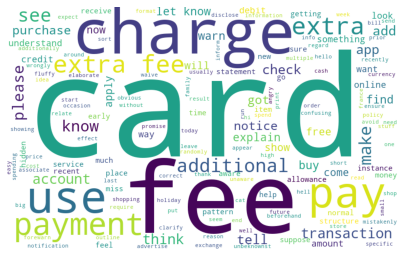

In [27]:
## word cloud for highest count for intent = 'card_payment_fee_charged'

intent_text = ""
for t in utterances[utterances['intent'] == 'card_payment_fee_charged']['lemmatized_utterance']:
    intent_text += t +" "
wordCloud = WordCloud(width=800, height=500, background_color='white').generate(intent_text)
plt.figure(figsize=(7,7))
plt.imshow(wordCloud)
plt.axis("Off")
plt.show()

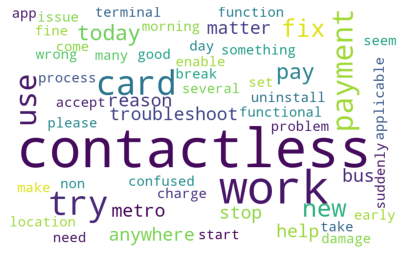

In [28]:
## word cloud for lowest count intent = 'contactless_not_working	'

intent_text = ""
for t in utterances[utterances['intent'] == 'contactless_not_working']['lemmatized_utterance']:
    intent_text += t +" "
wordCloud = WordCloud(width=800, height=500, background_color='white').generate(intent_text)
plt.figure(figsize=(7,7))
plt.imshow(wordCloud)
plt.axis("Off")
plt.show()

### Label Encode the class label i.e. 'intent' column

In [29]:
from sklearn import preprocessing

labelEncoding = preprocessing.LabelEncoder()
utterances['intent_labelEncoded'] = labelEncoding.fit_transform(utterances['intent']) 
utterances.head()

,utterance,intent,lemmatized_utterance,intent_labelEncoded
0,i am still waiting on my card,card_arrival,be still wait on my card,12
1,what can i do if my card still hasn't arrived ...,card_arrival,what can do if my card still have not arrive a...,12
2,i have been waiting over a week is the card st...,card_arrival,have be wait over week be the card still come,12
3,can i track my card while it is in the process...,card_arrival,can track my card while it be in the process o...,12
4,how do i know if i will get my card or if it i...,card_arrival,how do know if will get my card or if it be lose,12


### Model Building and testing using MultiNomialNB using Count Vectorizer and tf-idf Vectorizer


##### Method to display confusion matrix for the model evaluation.

In [ ]:
def plot_confusion_matrix(y_test, y_pred):
  y_labels = np.unique(y_test)
  cm = confusion_matrix(y_test, y_pred, labels=y_labels)
  cm_df = pd.DataFrame(cm, index=y_labels, columns=y_labels)
  cm_df.index.name= "Actual"
  cm_df.columns.name = "Predicted"
  fig, ax = plt.subplots(1, 1, figsize=(50, 50))
  sn.heatmap(cm_df, annot=True, ax=ax, linewidth=0.5, cmap="crest")
  plt.title("Confusion Matrix")
  plt.show()


##### Method to print total TP, FP, TN, FN

In [ ]:
def print_total_values(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
  TP = (np.diag(cm)).astype(float)
  FP = (cm.sum(axis=0) - np.diag(cm)).astype(float)
  FN = cm.sum(axis=1) - np.diag(cm).astype(float)
  TN = cm.sum() - (FP + FN + TP).astype(float)

  print(f"Total True Positives : ",np.sum(TP))
  print(f"Total False Positives : ",np.sum(FP))
  print(f"Total True Negatives : ",np.sum(TN))
  print(f"Total False Negatives : ",np.sum(FN))


##### Print TP, FP, TN, FN as part of classification report

In [ ]:
def multiclass_classification_report(y_test, y_pred):
    conf_labels = None
    
    conf_mat = multilabel_confusion_matrix(y_test, y_pred, labels=conf_labels)
    report = dict()
    counter = np.unique(y_test)
        
    for i, name in enumerate(counter):
        TN, FP, FN, TP = conf_mat[i].ravel()
        report[name] = {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN}
    
    return pd.DataFrame(report)


Model building using MultiNomialNB (Naive Bayes) Model and uni-gram CountVectorizer for Classification

In [ ]:
"""
Now convert each message into a vector that machine learning models can understand.

"""
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Initialize uni-gram CountVectorizer
vectorizer = CountVectorizer().fit_transform(utterances['lemmatized_utterance'])
X = np.array(vectorizer.todense())
#print("Shape of X: ", X.shape)
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
#print("Shape of X_train: ", X_train.shape)
#print("Shape of X_test: ", X_test.shape)

#display(y_test.value_counts(sort=True, ascending=True))

# Initalize MNB classifier and fit with features
count_vectorizer_unigram_MNB_model = MultinomialNB().fit(X_train, y_train)

# get the predictions for X_test using pipeline object
y_pred = count_vectorizer_unigram_MNB_model.predict(X_test)
#print(y_pred)

# get the model classification report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='weighted'))
print (classification_report(y_test, y_pred))

# Plot heatmap of confusion matrix
#plot_confusion_matrix(y_test, y_pred)

#Print total TP, FP, TN, FN
print_total_values(y_test, y_pred)

# Add TP, TN, FP, FN as part of classification report
display(multiclass_classification_report(y_test, y_pred))
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', 5)


Accuracy: 0.7807424593967517
F1 score: 0.7719180313891726
                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.76      0.97      0.85        29
                                activate_my_card       0.68      0.93      0.79        28
                                       age_limit       1.00      0.83      0.91        18
                         apple_pay_or_google_pay       0.95      0.95      0.95        22
                                     atm_support       1.00      0.43      0.60        14
                                automatic_top_up       0.88      0.95      0.91        22
         balance_not_updated_after_bank_transfer       0.73      0.71      0.72        31
balance_not_updated_after_cheque_or_cash_deposit       0.84      0.94      0.89        33
                         beneficiary_not_allowed       0.80      0.74      0.77        27
                                 cancel_t

,Refund_not_showing_up,activate_my_card,age_limit,apple_pay_or_google_pay,atm_support,automatic_top_up,balance_not_updated_after_bank_transfer,balance_not_updated_after_cheque_or_cash_deposit,beneficiary_not_allowed,cancel_transfer,card_about_to_expire,card_acceptance,card_arrival,card_delivery_estimate,card_linking,card_not_working,card_payment_fee_charged,card_payment_not_recognised,card_payment_wrong_exchange_rate,card_swallowed,cash_withdrawal_charge,cash_withdrawal_not_recognised,change_pin,compromised_card,contactless_not_working,country_support,declined_card_payment,declined_cash_withdrawal,declined_transfer,direct_debit_payment_not_recognised,disposable_card_limits,edit_personal_details,exchange_charge,exchange_rate,exchange_via_app,extra_charge_on_statement,failed_transfer,fiat_currency_support,get_disposable_virtual_card,get_physical_card,getting_spare_card,getting_virtual_card,lost_or_stolen_card,lost_or_stolen_phone,order_physical_card,passcode_forgotten,pending_card_payment,pending_cash_withdrawal,pending_top_up,pending_transfer,pin_blocked,receiving_money,request_refund,reverted_card_payment?,supported_cards_and_currencies,terminate_account,top_up_by_bank_transfer_charge,top_up_by_card_charge,top_up_by_cash_or_cheque,top_up_failed,top_up_limits,top_up_reverted,topping_up_by_card,transaction_charged_twice,transfer_fee_charged,transfer_into_account,transfer_not_received_by_recipient,transfer_timing,unable_to_verify_identity,verify_my_identity,verify_source_of_funds,verify_top_up,virtual_card_not_working,visa_or_mastercard,why_verify_identity,wrong_amount_of_cash_received,wrong_exchange_rate_for_cash_withdrawal
TP,28,26,15,21,6,21,22,31,20,28,22,2,23,5,21,4,31,26,25,2,30,24,21,6,3,18,20,25,19,26,20,19,18,15,13,25,16,20,7,13,10,10,4,21,5,13,19,21,24,19,18,7,23,21,20,16,12,18,17,19,11,25,6,31,25,13,26,19,8,10,16,19,1,18,11,31,22
TN,1686,1684,1706,1701,1710,1699,1685,1685,1692,1693,1692,1715,1677,1705,1696,1704,1670,1674,1687,1715,1689,1687,1703,1708,1718,1702,1682,1672,1700,1684,1693,1702,1703,1705,1704,1690,1692,1700,1704,1706,1698,1707,1711,1701,1702,1706,1692,1690,1695,1689,1704,1706,1692,1691,1689,1706,1705,1704,1704,1690,1707,1693,1706,1690,1689,1700,1676,1692,1705,1700,1702,1699,1718,1701,1697,1687,1682
FP,9,12,0,1,0,3,8,6,5,3,10,0,20,0,4,2,20,20,8,0,3,9,0,2,0,0,15,21,1,7,11,1,1,0,0,5,8,3,4,0,4,1,0,2,2,1,4,9,3,9,1,2,2,5,13,0,0,1,1,9,1,5,1,2,4,5,18,10,2,7,3,4,0,0,7,5,13
FN,1,2,3,1,8,1,9,2,7,0,0,7,4,14,3,14,3,4,4,7,2,4,0,8,3,4,7,6,4,7,0,2,2,4,7,4,8,1,9,5,12,6,9,0,15,4,9,4,2,7,1,9,7,7,2,2,7,1,2,6,5,1,11,1,6,6,4,3,9,7,3,2,5,5,9,1,7


Model building using MultiNomialNB (Naive Bayes) Model and bi-gram CountVectorizer for Classification

In [ ]:
# bi-gram CountVectorizer using pipeline approach

X = utterances['lemmatized_utterance']
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

#print("Shape of X_train: ", X_train.shape)
#print("Shape of X_test: ", X_test.shape)

# Creating a pipeline object
count_vector_MNB_pipeline = Pipeline([
    ('vectorizer_bigrams', CountVectorizer(ngram_range = (2, 2))), 
     ('Multi NB', MultinomialNB())         
])
 
# fit with features
count_vector_MNB_pipeline.fit(X_train, y_train)

# get the predictions for X_test using pipeline object
y_pred = count_vector_MNB_pipeline.predict(X_test)
#print(y_pred)

# get the model classification report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='weighted'))
print (classification_report(y_test, y_pred))

Accuracy: 0.765661252900232
F1 score: 0.7631289462925778
                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.84      0.72      0.78        29
                                activate_my_card       0.76      0.93      0.84        28
                                       age_limit       0.89      0.94      0.92        18
                         apple_pay_or_google_pay       0.76      1.00      0.86        22
                                     atm_support       0.89      0.57      0.70        14
                                automatic_top_up       0.94      0.77      0.85        22
         balance_not_updated_after_bank_transfer       0.79      0.71      0.75        31
balance_not_updated_after_cheque_or_cash_deposit       0.68      0.97      0.80        33
                         beneficiary_not_allowed       0.68      0.85      0.75        27
                                 cancel_tr

Model building using MultiNomialNB (Naive Bayes) Model and uni-gram and bi-gram CountVectorizer for Classification

In [ ]:
# uni-gram, bi-gram CountVectorizer
unibigram_vectorizer = CountVectorizer(ngram_range=(1,2)).fit_transform(utterances['lemmatized_utterance'])
X = np.array(unibigram_vectorizer.todense())
#print("Shape of X: ", X.shape)
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
#print("Shape of X_train: ", X_train.shape)
#print("Shape of X_test: ", X_test.shape)

# Initalize MNB classifier and fit with features
ctvectorizer_unibigram_MNB_model = MultinomialNB().fit(X_train, y_train)

# get the predictions for X_test using pipeline object
y_pred = ctvectorizer_unibigram_MNB_model.predict(X_test)

# get the model classification report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average=None))
print (classification_report(y_test, y_pred))

Accuracy: 0.8213457076566125
F1 score: [0.91803279 0.92857143 1.         0.95652174 0.52631579 0.9
 0.71052632 0.88571429 0.76923077 0.93333333 0.84615385 0.5
 0.84615385 0.625      0.88       0.84848485 0.7654321  0.69230769
 0.77142857 0.71428571 0.8358209  0.7037037  0.93023256 0.69565217
 0.66666667 0.9047619  0.78688525 0.725      0.80952381 0.86111111
 0.93023256 0.97674419 0.89473684 0.68965517 0.95       0.75471698
 0.73913043 0.88372093 0.70967742 0.83870968 0.75555556 0.84848485
 0.72727273 0.9047619  0.66666667 0.94117647 0.87719298 0.93877551
 0.74509804 0.76363636 0.9        0.72       0.91525424 0.89285714
 0.76595745 0.97142857 0.77419355 0.86486486 0.94444444 0.57692308
 0.9375     0.83333333 0.62068966 0.89855072 0.86153846 0.7804878
 0.76923077 0.72727273 0.75       0.68571429 0.97297297 0.82608696
 0.28571429 0.95652174 0.6875     0.83076923 0.81355932]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        29
      

Model building using MultiNomialNB (Naive Bayes) Model and uni-gram, bi-gram, tri-gram CountVectorizer for Classification

In [ ]:
# uni-gram, bi-gram, tri-gram CountVectorizer

trigram_vectorizer = CountVectorizer(ngram_range=(1,3)).fit_transform(utterances['lemmatized_utterance'])
X = np.array(trigram_vectorizer.todense())
#print("Shape of X: ", X.shape)
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
#print("Shape of X_train: ", X_train.shape)
#print("Shape of X_test: ", X_test.shape)

# Initalize MNB classifier and fit with features
ctvectorizer_trigram_MNB_model = MultinomialNB().fit(X_train, y_train)

# get the predictions for X_test using pipeline object
y_pred = ctvectorizer_trigram_MNB_model.predict(X_test)
#print(y_pred)

# get the model classification report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="weighted"))
print (classification_report(y_test, y_pred))

Accuracy: 0.8190255220417634
F1 score: 0.8152841541538577
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.74      0.93      0.83        28
           2       1.00      0.83      0.91        18
           3       0.92      1.00      0.96        22
           4       1.00      0.64      0.78        14
           5       0.95      0.95      0.95        22
           6       0.59      0.73      0.66        30
           7       0.79      0.94      0.86        33
           8       0.91      0.78      0.84        27
           9       0.82      0.96      0.89        28
          10       0.58      1.00      0.73        22
          11       1.00      0.33      0.50         9
          12       0.92      0.81      0.86        27
          13       1.00      0.47      0.64        19
          14       0.92      0.92      0.92        24
          15       0.71      0.56      0.63        18
          16       0.67

Model building using MultiNomialNB (Naive Bayes) Model and trigram CountVectorizer for Classification

In [ ]:
#tri-gram CountVectorizer

trigram_vectorizer = CountVectorizer(ngram_range=(3,3)).fit_transform(utterances['lemmatized_utterance'])
X = np.array(trigram_vectorizer.todense())
#print("Shape of X: ", X.shape)
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
#print("Shape of X_train: ", X_train.shape)
#print("Shape of X_test: ", X_test.shape)

# Initalize MNB classifier and fit with features
ctvectorizer_trigram_MNB_model = MultinomialNB().fit(X_train, y_train)

# get the predictions for X_test using pipeline object
y_pred = ctvectorizer_trigram_MNB_model.predict(X_test)
#print(y_pred)

# get the model classification report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average=None))
print (classification_report(y_test, y_pred))

Accuracy: 0.4385150812064965
F1 score: [0.53658537 0.5        0.43478261 0.82051282 0.         0.48275862
 0.62068966 0.56521739 0.45       0.61904762 0.71794872 0.
 0.6        0.41666667 0.75       0.4        0.07727273 0.5
 0.72       0.         0.55319149 0.65306122 0.72727273 0.42105263
 0.5        0.38709677 0.53658537 0.42307692 0.42424242 0.78571429
 0.74285714 0.64516129 0.66666667 0.63414634 0.51851852 0.48780488
 0.48484848 0.37037037 0.75862069 0.27272727 0.46666667 0.82758621
 0.         0.53333333 0.16666667 0.66666667 0.70833333 0.58536585
 0.55555556 0.58536585 0.68965517 0.45454545 0.65384615 0.65116279
 0.52631579 0.56       0.46153846 0.75       0.53846154 0.35294118
 0.21052632 0.36842105 0.61538462 0.58333333 0.57777778 0.68965517
 0.31818182 0.57142857 0.28571429 0.4        0.84848485 0.76470588
 0.5        0.68571429 0.4        0.54901961 0.73684211]
              precision    recall  f1-score   support

           0       0.92      0.38      0.54        29
      

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Model building using MultiNomialNB (Naive Bayes) Model and tf-idf (term frequency - inverse document frequency) vectorizer for Classification


In [ ]:
# Using TfidfVectorizer
tfidfVectorizer = TfidfVectorizer().fit_transform(utterances['lemmatized_utterance'])
X = np.array(tfidfVectorizer.todense())

y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
#print("Shape of X_train: ", X_train.shape)
#print("Shape of X_test: ", X_test.shape)

# Initalize MNB classifier and fit with features
tfidfvectorizer_MNB_model = MultinomialNB().fit(X_train, y_train)

# get the predictions for X_test using pipeline object
y_pred = tfidfvectorizer_MNB_model.predict(X_test)
#print(y_pred)

# get the model classification report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average=None))
print (classification_report(y_test, y_pred))

Accuracy: 0.7824825986078886
F1 score: [0.88888889 0.87719298 0.90909091 0.95454545 0.35294118 0.97674419
 0.68571429 0.81578947 0.83636364 0.82539683 0.82352941 0.
 0.82142857 0.64516129 0.82352941 0.33333333 0.6741573  0.73846154
 0.8115942  0.36363636 0.77333333 0.78571429 0.91304348 0.4
 0.5        0.68421053 0.81355932 0.62650602 0.76190476 0.76470588
 0.88888889 0.92682927 0.82051282 0.53846154 0.85714286 0.79245283
 0.82608696 0.80952381 0.83333333 0.8        0.71428571 0.82352941
 0.25       0.88888889 0.62857143 1.         0.9122807  0.875
 0.76595745 0.83333333 0.94736842 0.76923077 0.9        0.85185185
 0.65306122 0.94117647 0.72727273 0.75675676 0.88235294 0.62745098
 0.85714286 0.88461538 0.36363636 0.87323944 0.82352941 0.72222222
 0.78873239 0.63414634 0.82758621 0.66666667 0.88888889 0.93333333
 0.         0.88888889 0.61904762 0.74285714 0.6779661 ]
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        29
           

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# tf-idf vectorizer and MNB model using Pipeline approach

X = utterances['lemmatized_utterance']
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

# Creating a pipeline object
tfidf_vector_MNB_pipeline = Pipeline([
    ('vectorizer_tfidf', TfidfVectorizer()),        #using the ngram_range parameter 
     ('Multi NB', MultinomialNB())         
])
 
 #fit with features
tfidf_vector_MNB_pipeline.fit(X_train, y_train)

#get the predictions for X_test using pipeline object
y_pred = tfidf_vector_MNB_pipeline.predict(X_test)

# get the model classification report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="weighted"))
print (classification_report(y_test, y_pred))

Shape of X_train:  (6894,)
Shape of X_test:  (1724,)
Accuracy: 0.7888631090487239
F1 score: 0.7794771595404143
              precision    recall  f1-score   support

           0       0.89      0.83      0.86        29
           1       0.76      0.93      0.84        28
           2       1.00      0.94      0.97        18
           3       0.88      1.00      0.94        22
           4       1.00      0.21      0.35        14
           5       1.00      0.95      0.98        22
           6       0.59      0.61      0.60        31
           7       0.72      1.00      0.84        33
           8       0.71      0.63      0.67        27
           9       0.79      0.96      0.87        28
          10       0.81      1.00      0.90        22
          11       0.00      0.00      0.00         9
          12       0.79      0.85      0.82        27
          13       1.00      0.42      0.59        19
          14       0.87      0.83      0.85        24
          15       1.00 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Using KNN (K Nearest Neighbour) Model and CountVectorizer

##### Using ngram_range as unigram and bigram and metric as Euclidean distance.

In [ ]:
# CountVectorizer and KNN model using Pipeline approach 

X = utterances['lemmatized_utterance']
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Creating a pipeline object
count_vector_KNN1_pipeline = Pipeline([
    ('vectorizer_count', CountVectorizer()),        #using the ngram_range parameter 
     ('KNN', KNeighborsClassifier(n_neighbors=5, weights='distance', metric='euclidean'))         
])
 
 #fit with features
count_vector_KNN1_pipeline.fit(X_train, y_train)

#get the predictions of X_test using pieline object
y_pred = count_vector_KNN1_pipeline.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))

print (classification_report(y_test, y_pred))

Accuracy: 0.7482598607888631
F1 score: 0.7434387152806562
              precision    recall  f1-score   support

           0       0.75      0.83      0.79        29
           1       0.92      0.82      0.87        28
           2       0.77      0.94      0.85        18
           3       1.00      0.95      0.98        22
           4       0.60      0.86      0.71        14
           5       0.95      0.86      0.90        22
           6       0.51      0.77      0.61        30
           7       0.92      0.70      0.79        33
           8       0.71      0.74      0.73        27
           9       0.82      0.82      0.82        28
          10       0.93      0.59      0.72        22
          11       0.35      0.78      0.48         9
          12       0.48      0.81      0.60        27
          13       0.55      0.58      0.56        19
          14       1.00      0.75      0.86        24
          15       0.47      0.50      0.49        18
          16       0.71

##### Using ngram_range as unigram, bigram and trigram and metric as cosine distance.

In [ ]:
# CountVectorizer and KNN model using Pipeline approach 

X = utterances['lemmatized_utterance']
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Creating a pipeline object
count_vector_KNN2_pipeline = Pipeline([
    ('vectorizer_count', CountVectorizer()),       
     ('KNN', KNeighborsClassifier(n_neighbors=5, weights='distance', metric='cosine'))         
])
 
 #fit with features
count_vector_KNN2_pipeline.fit(X_train, y_train)

#get the predictions of X_test using pieline object
y_pred = count_vector_KNN2_pipeline.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))

print (classification_report(y_test, y_pred))

Accuracy: 0.79292343387471
F1 score: 0.7912271675526846
              precision    recall  f1-score   support

           0       1.00      0.72      0.84        29
           1       0.88      0.82      0.85        28
           2       0.94      0.89      0.91        18
           3       0.92      1.00      0.96        22
           4       0.86      0.86      0.86        14
           5       0.95      0.82      0.88        22
           6       0.55      0.74      0.63        31
           7       0.90      0.85      0.88        33
           8       0.89      0.63      0.74        27
           9       0.77      0.71      0.74        28
          10       0.95      0.86      0.90        22
          11       0.38      0.67      0.48         9
          12       0.51      0.70      0.59        27
          13       0.48      0.53      0.50        19
          14       0.88      0.92      0.90        24
          15       0.70      0.78      0.74        18
          16       0.79  

### Using KNN (K Nearest Neighbour) Model and TF-IDF Vectorizer

#####Using Euclidean distance metric.

In [ ]:
# TF-IDF Vectorizer and KNN model using Pipeline approach 

X = utterances['lemmatized_utterance']
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Creating a pipeline object
tfidf_vector_KNN1_pipeline = Pipeline([
    ('vectorizer_tfidf', TfidfVectorizer()),       
     ('KNN', KNeighborsClassifier(n_neighbors=10, weights='distance', metric='euclidean'))         
])
 
 #fit with features
tfidf_vector_KNN1_pipeline.fit(X_train, y_train)

#get the predictions of X_test using pieline object
y_pred = tfidf_vector_KNN1_pipeline.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))

print (classification_report(y_test, y_pred))

Accuracy: 0.7807424593967517
F1 score: 0.7756240965577252
              precision    recall  f1-score   support

           0       0.81      0.76      0.79        29
           1       0.93      0.96      0.95        28
           2       1.00      0.94      0.97        18
           3       1.00      1.00      1.00        22
           4       0.85      0.79      0.81        14
           5       1.00      0.91      0.95        22
           6       0.75      0.77      0.76        31
           7       0.91      0.88      0.89        33
           8       0.66      0.70      0.68        27
           9       0.81      0.79      0.80        28
          10       0.92      1.00      0.96        22
          11       0.33      0.22      0.27         9
          12       0.69      0.74      0.71        27
          13       0.63      0.63      0.63        19
          14       0.89      0.71      0.79        24
          15       0.75      0.67      0.71        18
          16       0.81

#####Using Cosine distance metric.

In [ ]:
# TF-IDF Vectorizer and KNN model using Pipeline approach 

X = utterances['lemmatized_utterance']
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Creating a pipeline object
tfidf_vector_KNN2_pipeline = Pipeline([
    ('vectorizer_tfidf', TfidfVectorizer()),       
     ('KNN', KNeighborsClassifier(n_neighbors=10, weights='distance', metric='cosine'))         
])
 
 #fit with features
tfidf_vector_KNN2_pipeline.fit(X_train, y_train)

#get the predictions of X_test using pieline object
y_pred = tfidf_vector_KNN2_pipeline.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))

print (classification_report(y_test, y_pred))

Accuracy: 0.79292343387471
F1 score: 0.7899973054059442
              precision    recall  f1-score   support

           0       0.93      0.86      0.89        29
           1       0.90      0.93      0.91        28
           2       1.00      0.94      0.97        18
           3       1.00      0.95      0.98        22
           4       0.91      0.71      0.80        14
           5       1.00      0.95      0.98        22
           6       0.65      0.65      0.65        31
           7       0.87      0.79      0.83        33
           8       0.85      0.81      0.83        27
           9       0.82      0.96      0.89        28
          10       1.00      0.86      0.93        22
          11       0.57      0.44      0.50         9
          12       0.68      0.85      0.75        27
          13       0.70      0.74      0.72        19
          14       0.91      0.88      0.89        24
          15       0.53      0.50      0.51        18
          16       0.86  

### Using SVM (Support Vector Machine) Model and TF-IDF Vectorizer

##### Using TF-IDF Vectorizer

In [ ]:
# TF-IDF Vectorizer and SVM model 

tfidfVectorizer = TfidfVectorizer().fit_transform(utterances['lemmatized_utterance'])
X = np.array(tfidfVectorizer.todense())

y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

SVM_classifier_model1 = SVC(kernel='linear', gamma='auto')

#fit with features
SVM_classifier_model1.fit(X_train, y_train)

#get the predictions of X_test using pieline object
y_pred = SVM_classifier_model1.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average=None)) #Weighted F1 score since data is imbalanced.

print (classification_report(y_test, y_pred))


Accuracy: 0.8950116009280742
F1 score: [0.96551724 0.88888889 1.         0.97674419 0.96296296 0.95454545
 0.6875     0.97058824 0.90909091 0.93103448 0.97674419 0.88888889
 0.77419355 0.87179487 0.93617021 0.77777778 0.94117647 0.87096774
 0.9        0.94736842 0.90322581 0.82758621 0.95       0.82758621
 0.90909091 0.90909091 0.77966102 0.84057971 0.85       0.90322581
 0.95       1.         0.93023256 0.97297297 0.97435897 0.83333333
 0.89795918 0.92682927 0.96774194 0.92307692 0.86363636 0.94117647
 0.86956522 1.         0.7804878  0.9375     0.85185185 0.89795918
 0.82352941 0.69387755 0.87179487 1.         0.96666667 0.89655172
 0.8372093  0.91891892 0.91428571 0.91891892 1.         0.83018868
 1.         0.85714286 0.68571429 0.96875    0.90625    0.92307692
 0.8        0.79069767 0.78787879 0.91891892 1.         1.
 0.8        0.97777778 0.86486486 0.95081967 0.88461538]
                                                  precision    recall  f1-score   support

                 

##### Using Count Vectorizer

In [ ]:
# Count Vectorizer with unigram and bigram range and SVC model

count_vectorizer = CountVectorizer(ngram_range=(1,2)).fit_transform(utterances['lemmatized_utterance'])
X = np.array(count_vectorizer.todense())
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

SVM_classifier_mode2 = SVC(kernel='linear', gamma='auto')

#fit with features
SVM_classifier_mode2.fit(X_train, y_train)

#get the predictions of X_test using pieline object
y_pred = SVM_classifier_mode2.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="weighted")) #Weighted F1 score since data is imbalanced.

print (classification_report(y_test, y_pred))


Accuracy: 0.8074245939675174
F1 score: 0.8089832770932689
              precision    recall  f1-score   support

           0       0.96      0.86      0.91        29
           1       0.92      0.86      0.89        28
           2       0.77      0.94      0.85        18
           3       1.00      1.00      1.00        22
           4       0.52      0.79      0.63        14
           5       1.00      0.86      0.93        22
           6       0.71      0.65      0.68        31
           7       0.88      0.88      0.88        33
           8       0.92      0.81      0.86        27
           9       1.00      0.79      0.88        28
          10       1.00      0.82      0.90        22
          11       0.62      0.89      0.73         9
          12       0.68      0.78      0.72        27
          13       0.67      0.63      0.65        19
          14       0.90      0.79      0.84        24
          15       0.71      0.83      0.77        18
          16       0.86

### Using RandomForest Classifier with TF-IDF Vectorizer and CountVectorizer

##### Using TF-IDF Vectorizer

In [ ]:
# Using RandomForestClassifier and TF-IDF Vectorizer

tfidfVectorizer = TfidfVectorizer().fit_transform(utterances['lemmatized_utterance'])
X = np.array(tfidfVectorizer.todense())

y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

randomForestClassifier1 = RandomForestClassifier()

#fit with features 
randomForestClassifier1.fit(X_train, y_train)

#get the predictions of X_test
y_pred = randomForestClassifier1.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='macro'))

print (classification_report(y_test, y_pred))


Accuracy: 0.8283062645011601
F1 score: 0.820368696900244
              precision    recall  f1-score   support

           0       0.87      0.96      0.92        28
           1       1.00      0.90      0.95        29
           2       0.95      0.95      0.95        21
           3       0.95      1.00      0.97        18
           4       0.77      0.91      0.83        11
           5       0.90      1.00      0.95        19
           6       0.54      0.68      0.60        22
           7       0.81      0.92      0.86        38
           8       0.83      0.78      0.81        32
           9       0.86      0.96      0.91        26
          10       0.73      1.00      0.84        16
          11       0.80      0.73      0.76        11
          12       0.68      0.85      0.76        20
          13       0.93      0.61      0.74        23
          14       0.93      0.89      0.91        28
          15       0.83      0.83      0.83        18
          16       0.93 

##### Using Count Vectorizer

In [ ]:
# Using RandomForestClassifier and Count Vectorizer 

countVectorizer = CountVectorizer(ngram_range=(1,2)).fit_transform(utterances['lemmatized_utterance'])
X = np.array(countVectorizer.todense())

y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

randomForestClassifier2 = RandomForestClassifier()

#fit with features 
randomForestClassifier2.fit(X_train, y_train)

#get the predictions of X_test
y_pred = randomForestClassifier2.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='macro'))
print (classification_report(y_test, y_pred))

Accuracy: 0.8114849187935035
F1 score: 0.8083794780908631
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        26
           1       0.95      0.83      0.88        23
           2       0.85      1.00      0.92        17
           3       0.91      1.00      0.95        21
           4       0.53      0.73      0.62        11
           5       1.00      0.81      0.89        21
           6       0.68      0.85      0.75        27
           7       0.88      0.88      0.88        26
           8       0.83      0.93      0.88        27
           9       0.85      0.96      0.90        24
          10       1.00      0.90      0.95        21
          11       0.67      0.83      0.74        12
          12       0.58      0.88      0.70        24
          13       0.47      0.80      0.59        10
          14       0.90      0.86      0.88        21
          15       0.95      0.78      0.86        23
          16       0.77

### Using RandomOverSampler to balance the imbalanced data

#### Using SVM

In [ ]:
# We will use TF-IDF Vectorizer with SVM Model (since SVM classifier above gives 
# highest accuracy so far) with RandomOverSampler to balance the data.


tfidfVectorizer = TfidfVectorizer().fit_transform(utterances['lemmatized_utterance'])
X = tfidfVectorizer.toarray()

y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

#Uncomment to see the distribution
#print("instances per class label in training data before oversampling.")
#display(Counter(y_train))

#Define RandomOverSampler 

randomOverSampler = RandomOverSampler(random_state=500)
X_train_ROS, y_train_ROS = randomOverSampler.fit_resample(X_train, y_train)

# Check the number of instanaces for each class in oversampled training data
#Uncomment to see the distribution
#print("instances per class label in training data after oversampling.")
#display(Counter(y_train_ROS))

SVM_classifier_model3 = SVC(kernel='linear', gamma='auto')

#fit with oversampled features 
SVM_classifier_model3.fit(X_train_ROS, y_train_ROS)

#get the predictions of X_test
y_pred = SVM_classifier_model3.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='weighted'))
print (classification_report(y_test, y_pred))

Accuracy: 0.8863109048723898
F1 score: 0.8865227549912972
                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       1.00      0.83      0.91        29
                                activate_my_card       0.90      0.93      0.91        28
                                       age_limit       1.00      0.94      0.97        18
                         apple_pay_or_google_pay       1.00      1.00      1.00        22
                                     atm_support       1.00      1.00      1.00        14
                                automatic_top_up       1.00      0.91      0.95        22
         balance_not_updated_after_bank_transfer       0.74      0.83      0.78        30
balance_not_updated_after_cheque_or_cash_deposit       0.87      1.00      0.93        33
                         beneficiary_not_allowed       0.90      0.96      0.93        27
                                 cancel_t

#### Using SMOTE to balance the imbalanced data

In [ ]:
# We will use TF-IDF Vectorizer with SVM Model (since SVM classifier above gives 
# highest accuracy so far) with SMOTE to balance the data.

tfidfVectorizer = TfidfVectorizer().fit_transform(utterances['lemmatized_utterance'])
X = np.array(tfidfVectorizer.todense())

y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Uncomment to see the distribution
#print("instances per class label in training data before oversampling.")
#display(Counter(y_train))

#Define SMOTE 

smote = SMOTE()
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

# Check the number of instanaces for each class in oversampled training data
#Uncomment to see the distribution
#print("instances per class label in training data after oversampling.")
#display(Counter(y_train_SMOTE))

SVM_classifier_model4 = SVC(kernel='linear', gamma='auto')

#fit with oversampled features 
SVM_classifier_model4.fit(X_train_SMOTE, y_train_SMOTE)

#get the predictions of X_test
y_pred = SVM_classifier_model4.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='weighted'))
print (classification_report(y_test, y_pred))

Accuracy: 0.9037122969837587
F1 score: 0.903725687351124
                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.96      1.00      0.98        24
                                activate_my_card       1.00      0.96      0.98        24
                                       age_limit       1.00      1.00      1.00        20
                         apple_pay_or_google_pay       1.00      0.96      0.98        25
                                     atm_support       1.00      1.00      1.00        12
                                automatic_top_up       1.00      0.96      0.98        25
         balance_not_updated_after_bank_transfer       0.74      0.82      0.78        28
balance_not_updated_after_cheque_or_cash_deposit       0.87      0.96      0.91        27
                         beneficiary_not_allowed       0.84      0.91      0.87        23
                                 cancel_tr

#### Using RandomForestClassifer and SMOTE

In [ ]:
# Using RandomForestClassifier and TF-IDF Vectorizer with OverSampling technique SMOTE

tfidfVectorizer = TfidfVectorizer().fit_transform(utterances['lemmatized_utterance'])
X = np.array(tfidfVectorizer.todense())

y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#Define SMOTE 
smote = SMOTE(random_state=777, k_neighbors=1)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

randomForestClassifier3 = RandomForestClassifier()

#fit with oversampled features 
randomForestClassifier3.fit(X_train_SMOTE, y_train_SMOTE)

#get the predictions of X_test
y_pred = randomForestClassifier3.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='weighted'))
print (classification_report(y_test, y_pred))

Accuracy: 0.8518948182521269
F1 score: 0.8516351483490162
                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.94      0.87      0.90        52
                                activate_my_card       0.94      0.88      0.91        33
                                       age_limit       0.87      0.93      0.90        14
                         apple_pay_or_google_pay       0.94      1.00      0.97        32
                                     atm_support       0.94      0.73      0.82        22
                                automatic_top_up       0.92      0.97      0.94        34
         balance_not_updated_after_bank_transfer       0.79      0.67      0.72        51
balance_not_updated_after_cheque_or_cash_deposit       0.86      0.96      0.91        46
                         beneficiary_not_allowed       0.86      0.77      0.81        39
                                 cancel_t

#### Using MultiNomialNB Classifier and SMOTE

In [ ]:
# Using TfidfVectorizer
tfidfVectorizer = TfidfVectorizer().fit_transform(utterances['lemmatized_utterance'])
X = np.array(tfidfVectorizer.todense())

y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
#print("Shape of X_train: ", X_train.shape)
#print("Shape of X_test: ", X_test.shape)

#Define SMOTE 
smote = SMOTE(random_state=777, k_neighbors=1)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

# Initalize MNB classifier and fit with features
MNB_model_SMOTE = MultinomialNB().fit(X_train_SMOTE, y_train_SMOTE)

# get the predictions for X_test using pipeline object
y_pred = MNB_model_SMOTE.predict(X_test)
#print(y_pred)

# get the model classification report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='weighted'))
print (classification_report(y_test, y_pred))

Accuracy: 0.830046403712297
F1 score: 0.8302245214120155
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        29
           1       0.90      0.96      0.93        28
           2       1.00      0.89      0.94        18
           3       0.88      1.00      0.94        22
           4       0.92      0.86      0.89        14
           5       1.00      1.00      1.00        22
           6       0.79      0.73      0.76        30
           7       0.91      0.88      0.89        33
           8       0.91      0.74      0.82        27
           9       0.81      0.93      0.87        28
          10       0.65      1.00      0.79        22
          11       0.86      0.67      0.75         9
          12       0.94      0.59      0.73        27
          13       0.79      0.58      0.67        19
          14       0.92      1.00      0.96        24
          15       0.90      0.50      0.64        18
          16       0.83 

### Building Neural Networks Using Word Embeddings

##### Model 1 - In this model, we will use Tokenizer to convert text to sequences, fit the tokenizer on a training data using most common words in vocabulary built using the same trainin data. Then, using SMOTE balance the imbalanced training set. We will then build a sequential model with Embedding Layer as the first layer with vocabulary size we obtained in previous steps, Outpur dim size as 100, and input length as 15 (this is the maximum length of utterance), Flatten layer and output Dense layer with 77 output space (since we have 77 different intent categories) and activation function as 'Softmax'. We will use 'rmsprop' optimizer with 'sparse_categorical_crossentropy' as loss function and metrics as 'accuracy' to evaluate the model.

In [30]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 3.0 MB/s eta 0:00:00


In [61]:
from keras.preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Input, GlobalAveragePooling1D,Dropout
from keras.initializers import he_normal


MAX_TEXT_LEN = 15
EMBEDDING_OUTPUT_DIM = 300

In [67]:
# split the dataset into training and testing

X = utterances['lemmatized_utterance']
y = utterances['intent_labelEncoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)


In [68]:
# Prepare tokenizer using Tokenizer

tokenizer_x = Tokenizer()
tokenizer_x.fit_on_texts(list(X_train))

In [69]:
# Get the most common words in dataset and get the vocab size using Tokenizer

threshold = 3

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in tokenizer_x.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<threshold):
        cnt=cnt+1
        freq=freq+value
    
common_words = tot_cnt - cnt

# Redefine tokenzier with most common words in dataset
tokenizer_x = Tokenizer(num_words=common_words)
tokenizer_x.fit_on_texts(list(X_train))

# Convert text sequences into integer sequences
dataset_x_train_seq = tokenizer_x.texts_to_sequences(X_train)
dataset_x_test_seq = tokenizer_x.texts_to_sequences(X_test)

# Padding the sequences with zeros upto maximum length
dataset_x_train_seq_pad = pad_sequences(dataset_x_train_seq, MAX_TEXT_LEN, padding="post")
dataset_x_test_seq_pad = pad_sequences(dataset_x_test_seq, MAX_TEXT_LEN, padding="post") 

#Define SMOTE 
smote = SMOTE(random_state=777, k_neighbors=1)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(dataset_x_train_seq_pad, y_train)

#size of vocabulary ( +1 for padding token)
dataset_voc_size = len(tokenizer_x.word_index) + 1

dataset_voc_size

1493

In [ ]:
# Define a sequential model
model_1 = Sequential()
model_1.add(Embedding(dataset_voc_size, EMBEDDING_OUTPUT_DIM, input_length=MAX_TEXT_LEN))
model_1.add(Flatten())
model_1.add(Dense(77, activation="softmax"))

#compile the model
model_1.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model summary
model_1.summary()

#fit the model with training data
model_1.fit(dataset_x_train_seq_pad, y_train, epochs=25, verbose=0)

#evaluatte the model
loss, accuracy = model_1.evaluate(dataset_x_test_seq_pad, y_test, verbose=0)
print("Accuracy: %f" % (accuracy * 100))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 14, 300)           235200    
                                                                 
 flatten_1 (Flatten)         (None, 4200)              0         
                                                                 
 dense_1 (Dense)             (None, 77)                323477    
                                                                 
Total params: 558,677
Trainable params: 558,677
Non-trainable params: 0
_________________________________________________________________
Accuracy: 73.085845


Model 2 - Using Embedding Layer, GlobalAveragePoolong1D, Dropout regularizer, 1 hidden Dense layer with 'relu' activation function, and output Dense layer with 'softmax' activation function.

In [ ]:
#defind drop_out_rate

drop_out_rate = 0.2

# Define a sequential model
model_2 = Sequential()
model_2.add(Embedding(dataset_voc_size, EMBEDDING_OUTPUT_DIM, input_length=MAX_TEXT_LEN))
model_2.add(GlobalAveragePooling1D())
model_2.add(Dropout(drop_out_rate))
model_2.add(Dense(512, activation='relu', kernel_initializer= he_normal(seed=40)))
model_2.add(Dense(77, activation="softmax", kernel_initializer= he_normal(seed=20)))

#compile the model
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model summary
model_2.summary()

#fit the model with training data
model_2.fit(dataset_x_train_seq_pad, y_train, epochs=500, verbose=0)

#evaluatte the model
loss, accuracy = model_2.evaluate(dataset_x_test_seq_pad, y_test, verbose=0)
print("Accuracy: %f" % (accuracy * 100))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 14, 300)           235200    
                                                                 
 global_average_pooling1d_2   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 300)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               154112    
                                                                 
 dense_7 (Dense)             (None, 77)                39501     
                                                                 
Total params: 428,813
Trainable params: 193,613
Non-trainable params: 235,200
__________________________________________

#### Using GloVe( Global Vectors) Pre-trained embedding layer

##### Model 3- Building neural network using pre-trained Embedding model GloVe. It's trained on global word-word co-occurrence matrix,  which tabulates how frequently words co-occur with one another in a given corpus. Using Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors]

In [72]:
# Load entire GloVe word embedding file into the memory as a dictionary of word to embedding array

embeddings_dict = dict()

def getEmbeddings(glove_url):
  f = open(glove_url)
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_dict[word] = coefs
  f.close()
  print('Loaded %s word vectors.' % len(embeddings_dict))
  return embeddings_dict

In [75]:
# create a weight matrix for words in the training dataset
embedding_matrix = np.zeros((dataset_voc_size,300))
embeddings = getEmbeddings("/content/drive/MyDrive/Dissertation/Topic_Analysis/glove.6B/glove.6B.300d.txt")
for word, i in tokenizer_x.word_index.items():
  embedding_vector = embeddings.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector


Loaded 400000 word vectors.


In [54]:
# Now, let's define the model with pre-trained weights from embedding matrix.
model_3 = Sequential()
#Since we chose 100d version of GloVe, we must defind output dimension as 100
model_3.add(Embedding(dataset_voc_size, 100, weights=[embedding_matrix], input_length=MAX_TEXT_LEN, trainable=False))
model_3.add(Flatten())
model_3.add(Dense(77, activation="softmax"))

#compile the model
model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model summary
model_3.summary()

#fit the model with training data
model_3.fit(dataset_x_train_seq_pad, y_train, epochs=100, verbose=0)

#evaluatte the model
loss, accuracy = model_3.evaluate(dataset_x_test_seq_pad, y_test, verbose=0)
print("Accuracy: %f" % (accuracy * 100))


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 15, 100)           147500    
                                                                 
 flatten_7 (Flatten)         (None, 1500)              0         
                                                                 
 dense_7 (Dense)             (None, 77)                115577    
                                                                 
Total params: 263,077
Trainable params: 115,577
Non-trainable params: 147,500
_________________________________________________________________
Accuracy: 61.078888


Model 4 - Using GloVe Embedding Layer, GlobalAveragePoolong1D, Dropout rate, 1 hidden Dense layer with 'relu' activation function, and output Dense layer with 'softmax' activation function.

In [82]:
# Define a sequential model
def getModelWithGloVe(embd_op_dimen, drop_out_rate):
  model_4 = Sequential()
  model_4.add(Embedding(dataset_voc_size, embd_op_dimen, weights=[embedding_matrix], input_length=MAX_TEXT_LEN, trainable=False))
  model_4.add(GlobalAveragePooling1D())
  model_4.add(Dropout(drop_out_rate))
  model_4.add(Dense(512, activation='relu', kernel_initializer= he_normal(seed=40)))
  model_4.add(Dense(77, activation="softmax", kernel_initializer= he_normal(seed=20)))
  return model_4

In [81]:
#compile the model with drop_out_rate

model_4 = getModelWithGloVe(300, 0.2)
model_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model summary
model_4.summary()

#fit the model with training data
model_4.fit(dataset_x_train_seq_pad, y_train, epochs=500, verbose=0)

#evaluatte the model
loss, accuracy = model_4.evaluate(dataset_x_test_seq_pad, y_test, verbose=0)
print("Accuracy: %f" % (accuracy * 100))

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 15, 300)           447900    
                                                                 
 global_average_pooling1d_5   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_18 (Dense)            (None, 512)               154112    
                                                                 
 dense_19 (Dense)            (None, 77)                39501     
                                                                 
Total params: 641,513
Trainable params: 193,613
Non-trainable params: 447,900
_________________________________________________________________
Accuracy: 81.554526


##### Using Deep CNN (Convolutional Neural Network) + GloVe

#### Using Word2Vec Pre-trained Embedding Layer

### Using Bidirectional Encoder Representations from Transformer (BERT)Pre-trained Transformer

### Exploring Deep Contextualized Word Representation  - ELMo (Embeddings from Language Models ) 

#### Using K-fold CrossValidation set

### Using Gensim library for text classification